# Product Review Sentiment Analysis & Topic Modeling

This notebook analyzes customer sentiment from product reviews to identify common themes, positive feedback, and pain points. The workflow covers data loading, preprocessing, sentiment analysis, exploration, and topic modeling.

#### **Objectives:**
- Load and explore the dataset
- Clean and preprocess review texts using spaCy
- Classify sentiment using TextBlob
- Visualize sentiment distributions and word clouds
- Analyze sentiment by product and over time
- Use topic modeling (LDA) to extract common negative themes
- Summarize insights and recommendations

> **Note:** This notebook uses `spaCy` for preprocessing and `TextBlob` for sentiment analysis. 

## 1. Data Loading & Initial Exploration

In [2]:
import pandas as pd

# Load the data
df = pd.read_csv('D:\internship\sentiment_analysis\Data\product_reviews_mock_data.csv')

# Show basic info
print(f"Shape: {df.shape}\nColumns: {df.columns.tolist()}")
df.head()

Shape: (1000, 6)
Columns: ['ReviewID', 'ProductID', 'UserID', 'Rating', 'ReviewText', 'ReviewDate']


,ReviewID,ProductID,UserID,Rating,ReviewText,ReviewDate
0,REV2000,Product_E,User_114,4,fantastic. wonderful experience.,2023-04-17
1,REV2001,Product_C,User_186,2,broke easily. awful.,2023-11-27
2,REV2002,Product_E,User_101,3,met expectations. five stars.,2023-12-10
3,REV2003,Product_A,User_175,5,very satisfied. wonderful experience.,2023-11-10
4,REV2004,Product_C,User_158,1,worst purchase. one star.,2024-05-25


### **Quick Data Overview**
- `ReviewID`: Unique identifier for the review
- `ProductID`: Product being reviewed
- `UserID`: Reviewer identifier
- `Rating`: Numeric rating (likely 1-5 scale)
- `ReviewText`: Textual review
- `ReviewDate`: Date of review

## 2. Text Preprocessing with spaCy

We'll use `spaCy` for:
- Lowercasing
- Removing punctuation, numbers, special characters
- Tokenization
- Stopword removal
- Lemmatization

In [3]:
import spacy
import re
from tqdm.auto import tqdm
tqdm.pandas()

nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"]) # Only for fast processing

def clean_spacy(text):
    text = str(text).lower()
    text = re.sub(r"[^a-z\s]", "", text)
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
    return " ".join(tokens)

df['CleanReviewText'] = df['ReviewText'].progress_apply(clean_spacy)

df[['ReviewText', 'CleanReviewText']].head()

c:\Users\OceanComputers\miniconda3\envs\sentiment_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 1000/1000 [00:07<00:00, 129.54it/s]


,ReviewText,CleanReviewText
0,fantastic. wonderful experience.,fantastic wonderful experience
1,broke easily. awful.,break easily awful
2,met expectations. five stars.,meet expectation star
3,very satisfied. wonderful experience.,satisfied wonderful experience
4,worst purchase. one star.,bad purchase star


## 3. Sentiment Analysis with TextBlob

We'll use TextBlob for quick polarity scoring (range -1 to 1):
- **positive** (> 0.1)
- **negative** (< -0.1)
- **neutral** (otherwise)

In [4]:
from textblob import TextBlob

def get_sentiment(text):
    score = TextBlob(text).sentiment.polarity
    if score > 0.1:
        return 'positive'
    elif score < -0.1:
        return 'negative'
    else:
        return 'neutral'

df['Sentiment'] = df['CleanReviewText'].apply(get_sentiment)
df['SentimentScore'] = df['CleanReviewText'].apply(lambda x: TextBlob(x).sentiment.polarity)
df[['CleanReviewText', 'Sentiment', 'SentimentScore']].head(10)

,CleanReviewText,Sentiment,SentimentScore
0,fantastic wonderful experience,positive,0.700000
1,break easily awful,negative,-1.000000
2,meet expectation star,neutral,0.000000
3,satisfied wonderful experience,positive,0.750000
4,bad purchase star,negative,-0.700000
5,pro con work perfectly,positive,1.000000
6,highly recommend amazing feature,positive,0.380000
7,waste money poor quality,negative,-0.300000
8,love product highly recommend special,positive,0.339048
9,poor quality bad purchase,negative,-0.550000


## 4. Exploratory Data Analysis (EDA) of Sentiments

C:\Users\OceanComputers\AppData\Local\Temp\ipykernel_4036\1595594485.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Sentiment', data=df, palette='coolwarm')


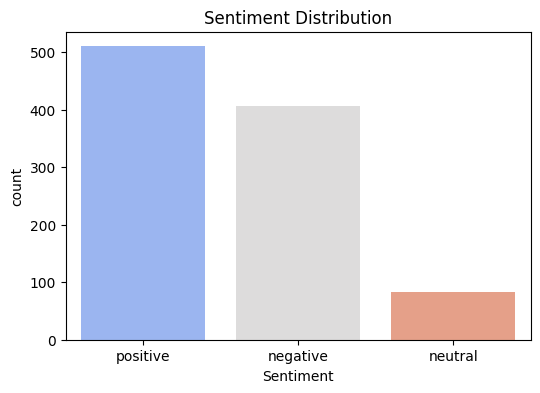

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Distribution of Sentiments
plt.figure(figsize=(6,4))
sns.countplot(x='Sentiment', data=df, palette='coolwarm')
plt.title("Sentiment Distribution")
plt.show()

### Word Clouds for Positive and Negative Reviews

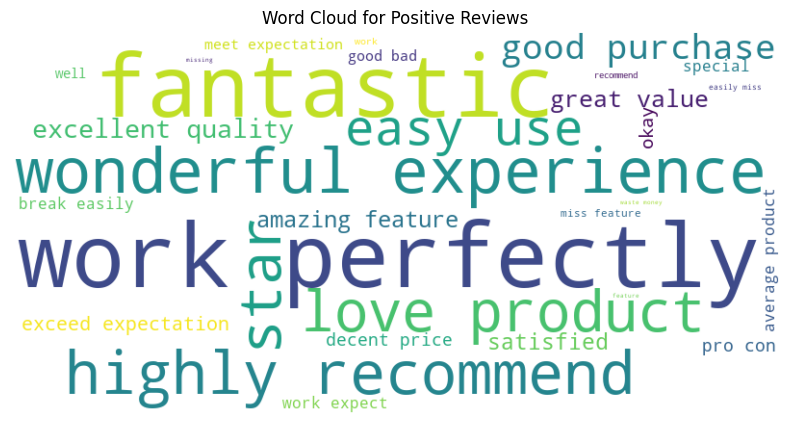

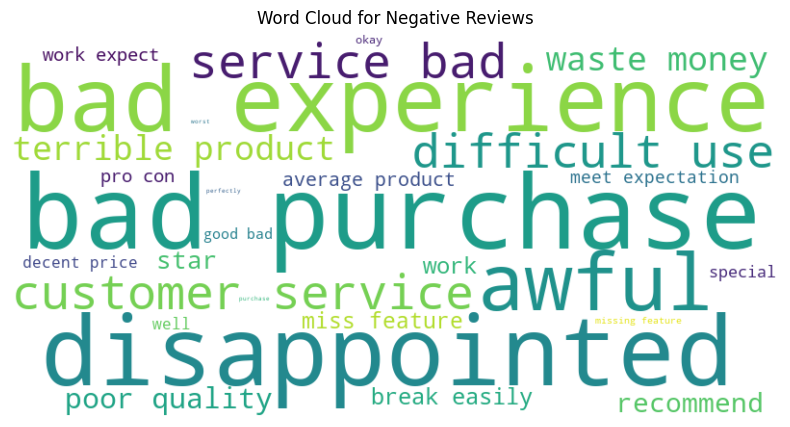

In [6]:
from wordcloud import WordCloud

for sentiment in ['positive', 'negative']:
    text = " ".join(df[df['Sentiment'] == sentiment]['CleanReviewText'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {sentiment.capitalize()} Reviews')
    plt.show()

### Sentiment by Product

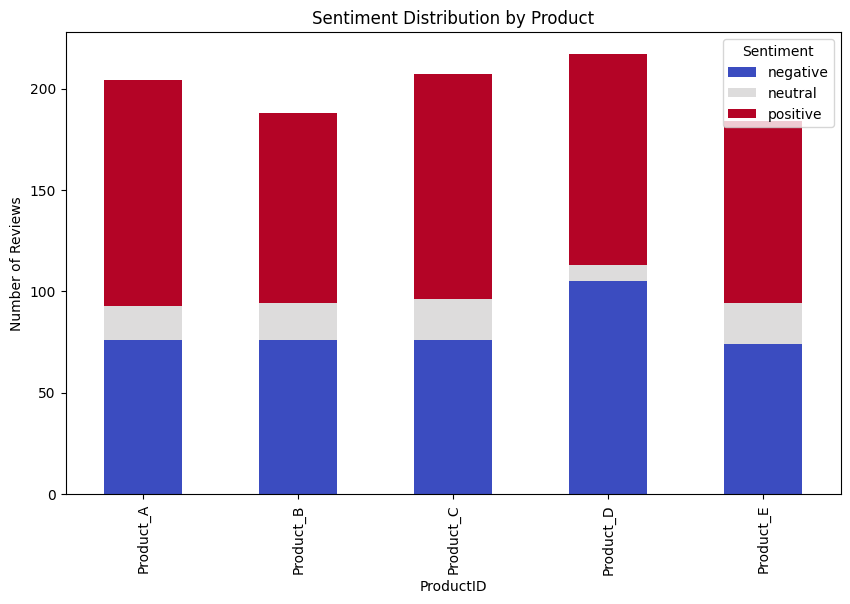

In [7]:
sentiment_product = df.groupby(['ProductID', 'Sentiment']).size().unstack().fillna(0)
sentiment_product.plot(kind='bar', stacked=True, figsize=(10,6), colormap='coolwarm')
plt.ylabel('Number of Reviews')
plt.title('Sentiment Distribution by Product')
plt.show()

### Sentiment Trends Over Time

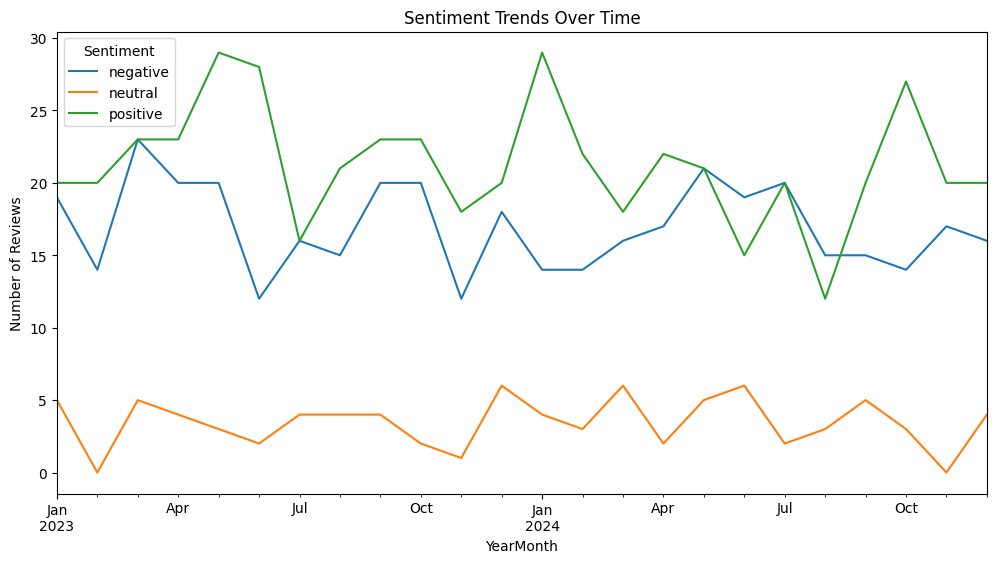

In [8]:
df['ReviewDate'] = pd.to_datetime(df['ReviewDate'])
df['YearMonth'] = df['ReviewDate'].dt.to_period('M')
sentiment_time = df.groupby(['YearMonth', 'Sentiment']).size().unstack().fillna(0)
sentiment_time.plot(kind='line', figsize=(12,6))
plt.title('Sentiment Trends Over Time')
plt.ylabel('Number of Reviews')
plt.show()

## 5. Topic Modeling on Negative Reviews (LDA)

- We'll use LDA to extract main topics from negative reviews.

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

neg_reviews = df[df['Sentiment'] == 'negative']
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
X = vectorizer.fit_transform(neg_reviews['CleanReviewText'])

lda = LatentDirichletAllocation(n_components=3, random_state=42)
lda.fit(X)

def display_topics(model, feature_names, no_top_words=8):
    for ix, topic in enumerate(model.components_):
        print(f"Topic {ix+1}:",
              " ".join([feature_names[i] for i in topic.argsort()[:-no_top_words-1:-1]]))

print("Top words per topic in negative reviews:")
display_topics(lda, vectorizer.get_feature_names_out(), 8)

Top words per topic in negative reviews:
Topic 1: bad customer service feature miss meet expectation price
Topic 2: bad product terrible poor quality work purchase disappointed
Topic 3: difficult use money waste bad break easily experience


## 6. Insight Generation & Recommendations

In [10]:
def summarize_findings(df):
    total = len(df)
    pos = (df['Sentiment']=='positive').sum()
    neg = (df['Sentiment']=='negative').sum()
    neu = (df['Sentiment']=='neutral').sum()
    print(f"Sentiment Breakdown: {pos/total:.1%} positive, {neg/total:.1%} negative, {neu/total:.1%} neutral\n")
    print("Common positive feedback examples:")
    print(df[df['Sentiment']=='positive']['CleanReviewText'].sample(5, random_state=1).to_list())
    print("\nCommon negative pain points:")
    print(df[df['Sentiment']=='negative']['CleanReviewText'].sample(5, random_state=1).to_list())

summarize_findings(df)

Sentiment Breakdown: 51.0% positive, 40.7% negative, 8.3% neutral

Common positive feedback examples:
['decent price fantastic', 'decent price amazing feature', 'highly recommend amazing feature', 'pro con highly recommend', 'star great value average product']

Common negative pain points:
['bad purchase work', 'bad experience awful', 'meet expectation awful', 'bad experience waste money', 'special awful']


### **Actionable Recommendations:**

- Highlight common positive aspects (e.g., 'easy to use', 'excellent quality') in marketing.
- Focus product improvement on major pain points (e.g., 'broke easily', 'customer service', 'missing features').
- Address the most frequent negative topics identified by LDA in product updates or support documentation.
- Monitor sentiment trends over time to detect changes after product updates.